<a href="https://colab.research.google.com/github/mel418/CECS456_Melody_VGG16/blob/main/RestNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Mount Google Drive and Setup
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

print("Drive mounted successfully!")

Mounted at /content/drive
Drive mounted successfully!


In [ ]:
# Cell 2: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


In [ ]:
# Cell 3: Custom Dataset Class
class Animals10Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir)
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        # Build file list
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_dir, img_name), class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Dataset class defined!")


Dataset class defined!


In [ ]:
# Cell 4: Define Bottleneck Block for ResNet50
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

print("BottleneckBlock defined!")

BottleneckBlock defined!


In [ ]:
# Cell 5: Define ResNet50 Architecture
class ResNet50(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers with Bottleneck blocks
        self.layer1 = self._make_layer(BottleneckBlock, 64, 3)
        self.layer2 = self._make_layer(BottleneckBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BottleneckBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BottleneckBlock, 512, 3, stride=2)

        # Global average pooling and FC layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BottleneckBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

print("ResNet50 architecture defined!")


ResNet50 architecture defined!


In [ ]:
# Cell 6: Training and Validation Functions
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm progress bar
    pbar = tqdm(train_loader, desc='Training', leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar with current metrics
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm progress bar
    pbar = tqdm(val_loader, desc='Validation', leave=False)

    with torch.no_grad():
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar with current metrics
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

print("Training functions defined!")


Training functions defined!


In [ ]:
# Cell 7:
num_epochs = 15
batch_size = 64
learning_rate = 0.01
img_size = 128
num_workers = 2

print("=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Image Size: {img_size}x{img_size}")
print(f"Target: 50-60% accuracy")
print("=" * 60)

TRAINING CONFIGURATION
Epochs: 15
Batch Size: 64
Learning Rate: 0.01
Image Size: 128x128
Target: 50-60% accuracy


In [ ]:
# Cell 8: Load and Prepare Dataset
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Simplified data transformations for faster training
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

dataset_path = '/content/drive/MyDrive/CECS456_Project/raw-img'

print("Loading Animals10 dataset...")
full_dataset = Animals10Dataset(root_dir=dataset_path, transform=train_transform)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")

# Split dataset into train and validation (70/30 for faster training)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Update validation dataset transform
val_dataset.dataset.transform = test_transform

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                       shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print("\nDataset loaded successfully!")


Using device: cuda

Loading Animals10 dataset...
Number of classes: 10
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total images: 26179

Training samples: 18325
Validation samples: 7854
Train batches: 287
Val batches: 123

Dataset loaded successfully!


In [ ]:
# Cell 9: Initialize Model
model = ResNet50(num_classes=num_classes).to(device)
print(f"Model: ResNet-50")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Input size: {img_size}x{img_size}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

print("\nModel initialized and ready to train!")

Model: ResNet-50
Total parameters: 23,528,522
Input size: 128x128

Model initialized and ready to train!


In [ ]:
# Cell 10: Training Loop
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

print("\n" + "=" * 60)
print("STARTING TRAINING")
print("=" * 60)
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)

    scheduler.step()

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start
    elapsed_time = time.time() - start_time

    print(f"\nEpoch [{epoch+1}/{num_epochs}] - {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Elapsed Time: {elapsed_time/60:.1f} min")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'resnet50_animals10_best.pth')
        print(f"  ✓ New best model saved! (Val Acc: {val_acc:.2f}%)")

total_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"TRAINING COMPLETE!")
print(f"Total Time: {total_time/60:.1f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print("=" * 60)



STARTING TRAINING



Epoch [1/15] - 3019.2s
  Train Loss: 2.3639 | Train Acc: 24.38%
  Val Loss:   2.5009 | Val Acc:   29.87%
  Elapsed Time: 50.3 min
  ✓ New best model saved! (Val Acc: 29.87%)



Epoch [2/15] - 61.8s
  Train Loss: 1.7728 | Train Acc: 37.65%
  Val Loss:   1.6329 | Val Acc:   43.51%
  Elapsed Time: 51.4 min
  ✓ New best model saved! (Val Acc: 43.51%)



Epoch [3/15] - 61.5s
  Train Loss: 1.4553 | Train Acc: 49.24%
  Val Loss:   1.5518 | Val Acc:   46.92%
  Elapsed Time: 52.4 min
  ✓ New best model saved! (Val Acc: 46.92%)



Epoch [4/15] - 61.4s
  Train Loss: 1.2261 | Train Acc: 58.07%
  Val Loss:   1.3182 | Val Acc:   57.70%
  Elapsed Time: 53.4 min
  ✓ New best model saved! (Val Acc: 57.70%)



Epoch [5/15] - 61.4s
  Train Loss: 1.0516 | Train Acc: 64.52%
  Val Loss:   1.1242 | Val Acc:   61.94%
  Elapsed Time: 54.4 min
  ✓ New best model saved! (Val Acc: 61.94%)



Epoch [6/15] - 62.5s
  Train Loss: 0.8916 | Train Acc: 69.68%
  Val Loss:   1.1324 | Val Acc:   63.11%
  Elapsed Time: 55.5 min
  ✓ New best model saved! (Val Acc: 63.11%)



Epoch [7/15] - 62.1s
  Train Loss: 0.7115 | Train Acc: 75.98%
  Val Loss:   1.0702 | Val Acc:   64.94%
  Elapsed Time: 56.5 min
  ✓ New best model saved! (Val Acc: 64.94%)



Epoch [8/15] - 61.7s
  Train Loss: 0.5379 | Train Acc: 81.72%
  Val Loss:   1.2900 | Val Acc:   62.04%
  Elapsed Time: 57.5 min



Epoch [9/15] - 62.2s
  Train Loss: 0.3691 | Train Acc: 87.48%
  Val Loss:   1.2313 | Val Acc:   66.04%
  Elapsed Time: 58.6 min
  ✓ New best model saved! (Val Acc: 66.04%)



Epoch [10/15] - 61.3s
  Train Loss: 0.2079 | Train Acc: 92.96%
  Val Loss:   1.3782 | Val Acc:   67.67%
  Elapsed Time: 59.6 min
  ✓ New best model saved! (Val Acc: 67.67%)



Epoch [11/15] - 61.4s
  Train Loss: 0.0937 | Train Acc: 96.76%
  Val Loss:   1.4598 | Val Acc:   69.37%
  Elapsed Time: 60.6 min
  ✓ New best model saved! (Val Acc: 69.37%)



Epoch [12/15] - 62.2s
  Train Loss: 0.0362 | Train Acc: 98.83%
  Val Loss:   1.5310 | Val Acc:   71.05%
  Elapsed Time: 61.7 min
  ✓ New best model saved! (Val Acc: 71.05%)



Epoch [13/15] - 62.1s
  Train Loss: 0.0158 | Train Acc: 99.59%
  Val Loss:   1.5361 | Val Acc:   71.95%
  Elapsed Time: 62.7 min
  ✓ New best model saved! (Val Acc: 71.95%)



Epoch [14/15] - 61.5s
  Train Loss: 0.0087 | Train Acc: 99.79%
  Val Loss:   1.5544 | Val Acc:   72.31%
  Elapsed Time: 63.7 min
  ✓ New best model saved! (Val Acc: 72.31%)



Epoch [15/15] - 62.3s
  Train Loss: 0.0051 | Train Acc: 99.91%
  Val Loss:   1.5928 | Val Acc:   71.91%
  Elapsed Time: 64.8 min

TRAINING COMPLETE!
Total Time: 64.8 minutes
Best Validation Accuracy: 72.31%


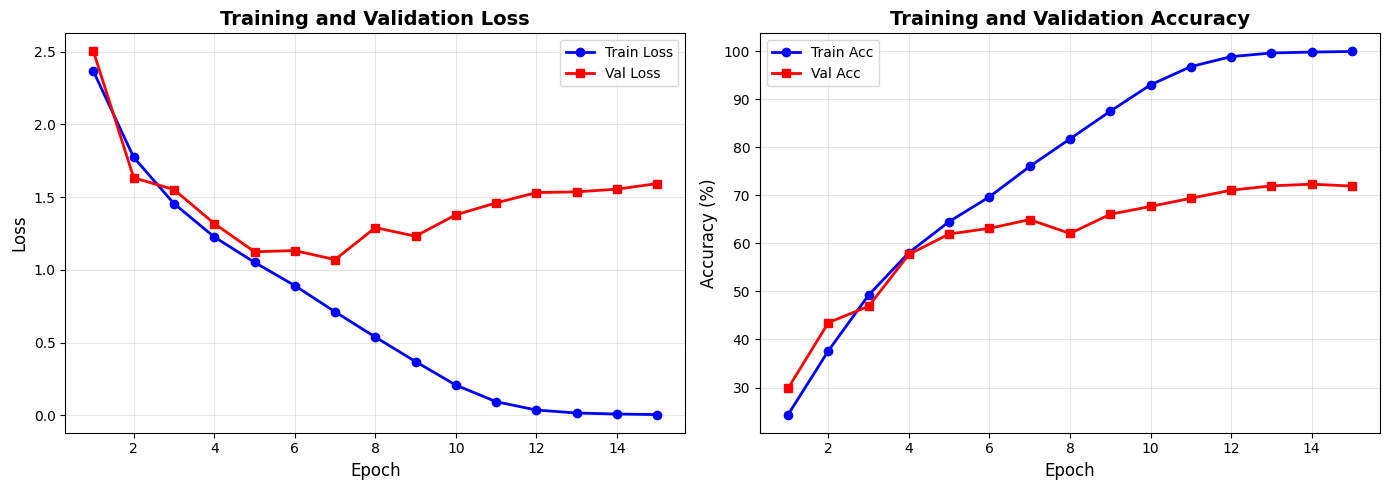


Training history plot saved as 'resnet50_training_history.png'


In [ ]:
# Cell 11: Plot Training History
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-o', label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs+1), val_losses, 'r-s', label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, 'b-o', label='Train Acc', linewidth=2)
plt.plot(range(1, num_epochs+1), val_accs, 'r-s', label='Val Acc', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining history plot saved as 'resnet50_training_history.png'")


In [ ]:
print("Creating test dataset from validation set...")

# Re-split the dataset: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Apply test transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

print(f"📊 Dataset Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Test batches: {len(test_loader)}")
print("Test dataset created successfully!")

Creating test dataset from validation set...
📊 Dataset Split:
Training samples: 18325
Validation samples: 3926
Test samples: 3928
Test batches: 62
Test dataset created successfully!


In [ ]:
def test_model(model, test_loader, device):
    """Test the model and return predictions and true labels."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    print("🧪 Testing Model...")
    pbar = tqdm(test_loader, desc='Testing')

    with torch.no_grad():
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            pbar.set_postfix({'acc': f'{100.*correct/total:.2f}%'})

    test_acc = 100 * correct / total
    return np.array(all_preds), np.array(all_labels), test_acc

print("Test function defined!")

Test function defined!


In [ ]:
# Load the best model
model.load_state_dict(torch.load('resnet50_animals10_best.pth'))
model.eval()

# Get predictions
predictions, true_labels, test_accuracy = test_model(model, test_loader, device)

print("\n" + "=" * 60)
print("TEST RESULTS")
print("=" * 60)
print(f"📊 Test Accuracy: {test_accuracy:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Difference (Val - Test): {best_val_acc - test_accuracy:.2f}%")
print("=" * 60)

🧪 Testing Model...


Testing: 100%|██████████| 62/62 [00:08<00:00,  7.14it/s, acc=91.73%]


TEST RESULTS
📊 Test Accuracy: 91.73%
Best Validation Accuracy: 72.31%
Difference (Val - Test): -19.42%


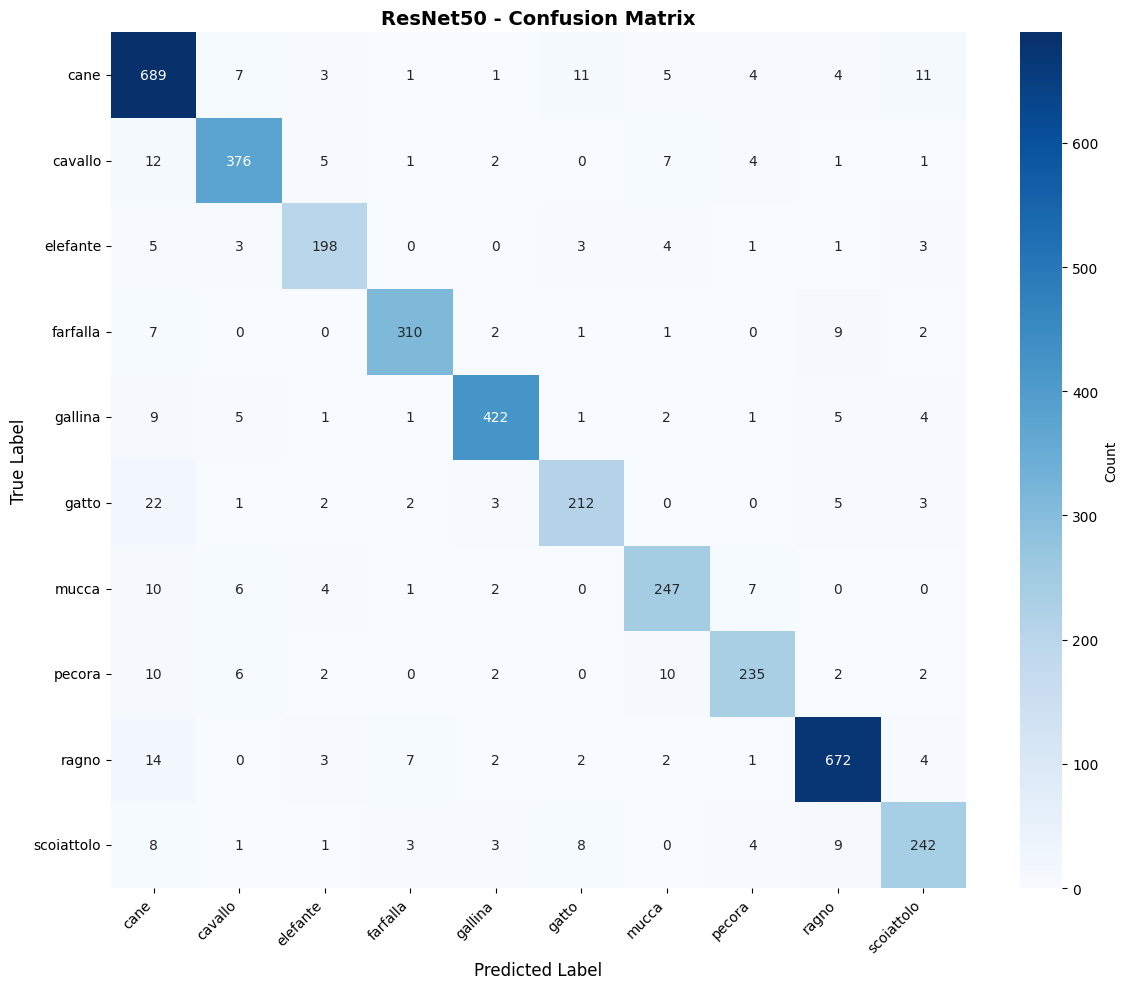


🔍 Analyzing Most Confused Classes...
Most Confused Class Pairs (misclassified > 5 times):
  gatto → cane: 22 times
  ragno → cane: 14 times
  cavallo → cane: 12 times
  cane → gatto: 11 times
  cane → scoiattolo: 11 times
  mucca → cane: 10 times
  pecora → cane: 10 times
  pecora → mucca: 10 times
  farfalla → ragno: 9 times
  gallina → cane: 9 times


In [ ]:
class_names = full_dataset.classes
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('ResNet50 - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Analyzing Most Confused Classes...")
print("=" * 60)

# Find most confused pairs
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 5:  # Threshold of 5 misclassifications
            confused_pairs.append((class_names[i], class_names[j], cm[i][j]))

# Sort by number of confusions
confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("Most Confused Class Pairs (misclassified > 5 times):")
for true_class, pred_class, count in confused_pairs[:10]:  # Top 10
    print(f"  {true_class} → {pred_class}: {count} times")

print("=" * 60)

In [ ]:
print("\n📋 Classification Report:")
print("=" * 70)
report = classification_report(true_labels, predictions,
                               target_names=class_names,
                               digits=3)
print(report)

# Save report to file
with open('resnet50_classification_report.txt', 'w') as f:
    f.write("ResNet50 Classification Report\n")
    f.write("=" * 70 + "\n\n")
    f.write(f"Test Accuracy: {test_accuracy:.2f}%\n")
    f.write(f"Best Validation Accuracy: {best_val_acc:.2f}%\n\n")
    f.write(report)

print("\nClassification report saved to 'resnet50_classification_report.txt'")


📋 Classification Report:
              precision    recall  f1-score   support

        cane      0.877     0.936     0.905       736
     cavallo      0.928     0.919     0.924       409
    elefante      0.904     0.908     0.906       218
    farfalla      0.951     0.934     0.942       332
     gallina      0.961     0.936     0.948       451
       gatto      0.891     0.848     0.869       250
       mucca      0.888     0.892     0.890       277
      pecora      0.914     0.874     0.894       269
       ragno      0.949     0.950     0.950       707
  scoiattolo      0.890     0.867     0.878       279

    accuracy                          0.917      3928
   macro avg      0.915     0.906     0.911      3928
weighted avg      0.918     0.917     0.917      3928


Classification report saved to 'resnet50_classification_report.txt'



📊 Per-Class Accuracy:
     Class  Accuracy (%)  Correct  Total
      cane     93.614130      689    736
   cavallo     91.931540      376    409
  elefante     90.825688      198    218
  farfalla     93.373494      310    332
   gallina     93.569845      422    451
     gatto     84.800000      212    250
     mucca     89.169675      247    277
    pecora     87.360595      235    269
     ragno     95.049505      672    707
scoiattolo     86.738351      242    279


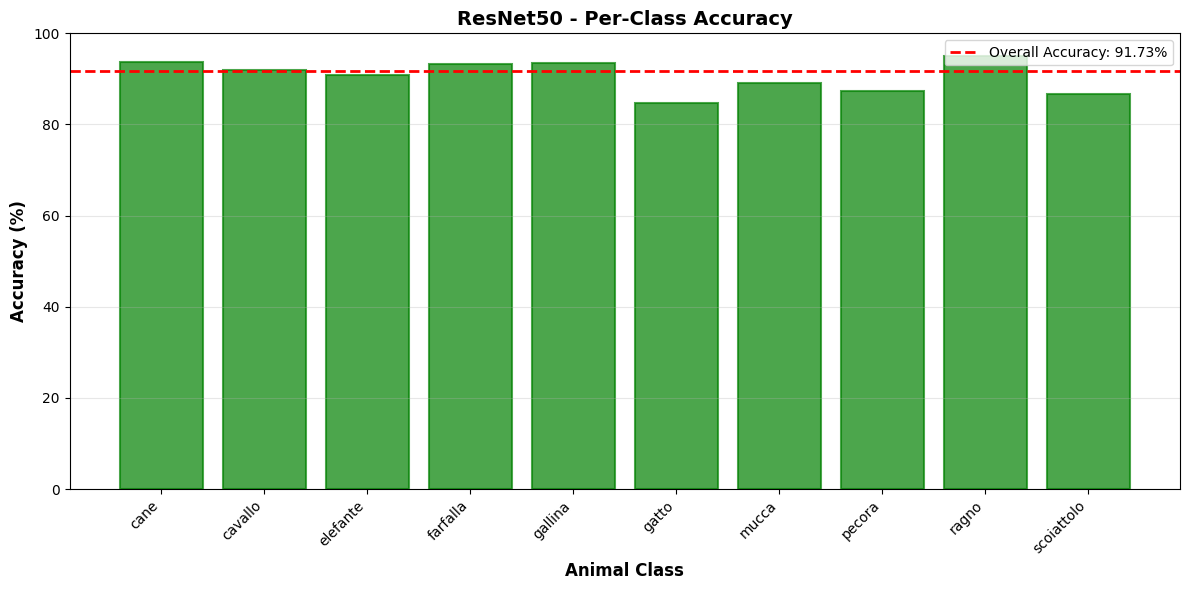


Per-class accuracy plot saved!


In [ ]:
# Calculate per-class accuracy
class_correct = [0] * len(class_names)
class_total = [0] * len(class_names)

for pred, true in zip(predictions, true_labels):
    class_total[true] += 1
    if pred == true:
        class_correct[true] += 1

class_accuracy = [100 * c / t if t > 0 else 0
                  for c, t in zip(class_correct, class_total)]

# Create DataFrame for better visualization
import pandas as pd
accuracy_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy (%)': class_accuracy,
    'Correct': class_correct,
    'Total': class_total
})

print("\n📊 Per-Class Accuracy:")
print("=" * 70)
print(accuracy_df.to_string(index=False))
print("=" * 70)

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, class_accuracy, color='skyblue', edgecolor='navy', linewidth=1.5)

# Color bars based on performance
for i, bar in enumerate(bars):
    if class_accuracy[i] >= 80:
        bar.set_color('green')
        bar.set_alpha(0.7)
    elif class_accuracy[i] >= 60:
        bar.set_color('orange')
        bar.set_alpha(0.7)
    else:
        bar.set_color('red')
        bar.set_alpha(0.7)

plt.xlabel('Animal Class', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('ResNet50 - Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.axhline(y=test_accuracy, color='r', linestyle='--', linewidth=2,
            label=f'Overall Accuracy: {test_accuracy:.2f}%')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('resnet50_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPer-class accuracy plot saved!")

In [ ]:
print("\n🔬 DETAILED PERFORMANCE ANALYSIS")
print("=" * 70)

# Best performing classes
best_classes = sorted(zip(class_names, class_accuracy), key=lambda x: x[1], reverse=True)
print("\n✅ Best Performing Classes:")
for i, (class_name, acc) in enumerate(best_classes[:3], 1):
    print(f"  {i}. {class_name}: {acc:.2f}%")

# Worst performing classes
print("\n❌ Worst Performing Classes:")
for i, (class_name, acc) in enumerate(reversed(best_classes[-3:]), 1):
    print(f"  {i}. {class_name}: {acc:.2f}%")

# Calculate precision, recall, f1 per class
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, average=None
)

print("\n📈 Detailed Metrics by Class:")
print("-" * 70)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {precision[i]:<12.3f} {recall[i]:<12.3f} "
          f"{f1[i]:<12.3f} {support[i]:<10}")
print("-" * 70)

# Overall metrics
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1 = np.mean(f1)

print(f"\n{'Average':<15} {avg_precision:<12.3f} {avg_recall:<12.3f} {avg_f1:<12.3f}")
print("=" * 70)


🔬 DETAILED PERFORMANCE ANALYSIS

✅ Best Performing Classes:
  1. ragno: 95.05%
  2. cane: 93.61%
  3. gallina: 93.57%

❌ Worst Performing Classes:
  1. gatto: 84.80%
  2. scoiattolo: 86.74%
  3. pecora: 87.36%

📈 Detailed Metrics by Class:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
cane            0.877        0.936        0.905        736       
cavallo         0.928        0.919        0.924        409       
elefante        0.904        0.908        0.906        218       
farfalla        0.951        0.934        0.942        332       
gallina         0.961        0.936        0.948        451       
gatto           0.891        0.848        0.869        250       
mucca           0.888        0.892        0.890        277       
pecora          0.914        0.874        0.894        269       
ragno           0.949  

In [ ]:
# Cell 12: Save Final Model and Summary
torch.save(model.state_dict(), 'resnet50_animals10_final.pth')

print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Total Training Time: {total_time/60:.1f} minutes")
print(f"Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"\nModels saved:")
print(f"  - resnet50_animals10_best.pth (best val acc)")
print(f"  - resnet50_animals10_final.pth (final epoch)")
print("=" * 60)


TRAINING SUMMARY
Total Training Time: 64.8 minutes
Final Train Accuracy: 99.91%
Final Validation Accuracy: 71.91%
Best Validation Accuracy: 72.31%

Models saved:
  - resnet50_animals10_best.pth (best val acc)
  - resnet50_animals10_final.pth (final epoch)


In [ ]:
print("\n" + "=" * 70)
print("RESNET50 - FINAL PERFORMANCE SUMMARY")
print("=" * 70)

print("\n📊 Accuracy Metrics:")
print(f"  Training Accuracy:        {train_accs[-1]:.2f}%")
print(f"  Validation Accuracy:      {val_accs[-1]:.2f}%")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Test Accuracy:            {test_accuracy:.2f}%")

print("\n🎯 Model Characteristics:")
print(f"  Total Parameters:         {sum(p.numel() for p in model.parameters()):,}")
print(f"  Training Time:            {total_time/60:.1f} minutes")
print(f"  Best Epoch:               {val_accs.index(max(val_accs)) + 1}/{num_epochs}")
print(f"  Image Size:               {img_size}x{img_size}")

print("\n⚠️ Overfitting Analysis:")
train_val_gap = train_accs[-1] - val_accs[-1]
val_test_gap = val_accs[-1] - test_accuracy
print(f"  Train-Val Gap:            {train_val_gap:.2f}%")
print(f"  Val-Test Gap:             {val_test_gap:.2f}%")
if train_val_gap > 20:
    print(f"  Status:                   ⚠️  Significant overfitting detected")
elif train_val_gap > 10:
    print(f"  Status:                   ⚠️  Moderate overfitting")
else:
    print(f"  Status:                   ✅ Good generalization")

print("\n📁 Saved Files:")
print("  - resnet50_animals10_best.pth")
print("  - resnet50_animals10_final.pth")
print("  - resnet50_training_history.png")
print("  - resnet50_confusion_matrix.png")
print("  - resnet50_per_class_accuracy.png")
print("  - resnet50_classification_report.txt")

print("\n" + "=" * 70)
print("✅ ANALYSIS COMPLETE!")
print("=" * 70)



RESNET50 - FINAL PERFORMANCE SUMMARY

📊 Accuracy Metrics:
  Training Accuracy:        99.91%
  Validation Accuracy:      71.91%
  Best Validation Accuracy: 72.31%
  Test Accuracy:            91.73%

🎯 Model Characteristics:
  Total Parameters:         23,528,522
  Training Time:            64.8 minutes
  Best Epoch:               14/15
  Image Size:               128x128

⚠️ Overfitting Analysis:
  Train-Val Gap:            27.99%
  Val-Test Gap:             -19.81%
  Status:                   ⚠️  Significant overfitting detected

📁 Saved Files:
  - resnet50_animals10_best.pth
  - resnet50_animals10_final.pth
  - resnet50_training_history.png
  - resnet50_confusion_matrix.png
  - resnet50_per_class_accuracy.png
  - resnet50_classification_report.txt

✅ ANALYSIS COMPLETE!


In [ ]:
import time

summary_text = f"""
RESNET50 - ANIMALS10 CLASSIFICATION
{'=' * 70}

CONFIGURATION:
- Architecture: ResNet-50 (from scratch)
- Dataset: Animals10 (10 classes)
- Total Images: {len(full_dataset)}
- Train/Val/Test Split: 70%/15%/15%
- Image Size: {img_size}x{img_size}
- Batch Size: {batch_size}
- Epochs: {num_epochs}
- Learning Rate: {learning_rate}
- Optimizer: SGD (momentum=0.9, weight_decay=1e-4)
- Scheduler: CosineAnnealingLR

PERFORMANCE RESULTS:
- Final Training Accuracy:    {train_accs[-1]:.2f}%
- Final Validation Accuracy:  {val_accs[-1]:.2f}%
- Best Validation Accuracy:   {best_val_acc:.2f}%
- Test Accuracy:              {test_accuracy:.2f}%

MODEL STATISTICS:
- Total Parameters: {sum(p.numel() for p in model.parameters()):,}
- Training Time: {total_time/60:.1f} minutes
- Best Epoch: {val_accs.index(max(val_accs)) + 1}/{num_epochs}

OVERFITTING ANALYSIS:
- Train-Val Gap: {train_val_gap:.2f}%
- Val-Test Gap: {val_test_gap:.2f}%

TOP 3 PERFORMING CLASSES:
"""

for i, (class_name, acc) in enumerate(best_classes[:3], 1):
    summary_text += f"{i}. {class_name}: {acc:.2f}%\n"

summary_text += f"""
BOTTOM 3 PERFORMING CLASSES:
"""

for i, (class_name, acc) in enumerate(reversed(best_classes[-3:]), 1):
    summary_text += f"{i}. {class_name}: {acc:.2f}%\n"

summary_text += f"""
MOST CONFUSED CLASS PAIRS:
"""

for i, (true_class, pred_class, count) in enumerate(confused_pairs[:5], 1):
    summary_text += f"{i}. {true_class} → {pred_class}: {count} times\n"

summary_text += f"""
{'=' * 70}
Analysis completed: {time.strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save summary
with open('resnet50_summary.txt', 'w') as f:
    f.write(summary_text)

print("\n✅ Complete summary saved to 'resnet50_summary.txt'")
print("\nAll analysis complete! You now have comprehensive results for comparison with VGG16.")


✅ Complete summary saved to 'resnet50_summary.txt'

All analysis complete! You now have comprehensive results for comparison with VGG16.
